# Sort Variable Length Lists

## Import

In [1]:
!pip install git+https://github.com/neelnanda-io/TransformerLens
!pip install circuitsvis

  Cloning https://github.com/neelnanda-io/TransformerLens to /tmp/pip-req-build-qymhkugd
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/TransformerLens /tmp/pip-req-build-qymhkugd
  Resolved https://github.com/neelnanda-io/TransformerLens to commit 0825c5eb4196e7ad72d28bcf4e615306b3897490
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.6/412.6 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import random
import numpy as np
import torch
from torch import nn, tensor, Tensor, TensorType as TT
from torch.nn import functional as F
from transformer_lens import HookedTransformerConfig, HookedTransformer
import transformer_lens.utils as utils
import circuitsvis as cv
from tqdm.auto import tqdm
from fancy_einsum import einsum

from matplotlib import pyplot as plt
import plotly.io as pio
import plotly.express as px

In [3]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install git+https://github.com/neelnanda-io/neel-plotly.git

  Cloning https://github.com/neelnanda-io/neel-plotly.git to /tmp/pip-req-build-7vs5ip18
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/neel-plotly.git /tmp/pip-req-build-7vs5ip18
  Resolved https://github.com/neelnanda-io/neel-plotly.git to commit 6dc24b26f8dec991908479d7445dae496b3430b7
  Preparing metadata (setup.py) ... done
  Created wheel for neel-plotly: filename=neel_plotly-0.0.0-py3-none-any.whl size=10186 sha256=43fffeb7a6f8b1c12cbc5219ceb63dc65cb849fdaf7a13fbe660379abe8f8675
  Stored in directory: /tmp/pip-ephem-wheel-cache-nixbcust/wheels/32/cf/25/0103b4be02266c40faf008ffa9565a2ba07d1c63118fccc390
Successfully built neel-plotly


## Graphing Config

In [4]:
pio.renderers.default = "colab"
pio.templates['plotly'].layout.xaxis.title.font.size = 20
pio.templates['plotly'].layout.yaxis.title.font.size = 20
pio.templates['plotly'].layout.title.font.size = 30

def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

## Variable Hyperparameters

In [5]:
# Input/label length
LIST_LENGTH = 102

# Size of vocabulary
D_VOCAB = 202

# Repetitions?
ALLOW_REPETITIONS = False

# Attention only?
ATTN_ONLY = True

# Positional encoding?
POS_EM = False

# Model dimenions
N_LAYERS = 1
N_HEADS = 1
D_MODEL = 128
D_HEAD = 32

D_MLP = None

if ATTN_ONLY:
    D_MLP = None

# Default batch size
DEFAULT_BATCH_SIZE = 128

## Invariable Hyperparameters

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{DEVICE = }")

# Seeds
TRAIN_SEED = 506
VAL_SEED = 234
TEST_SEED = 39539

# Max sequence length
N_CTX = 2 * LIST_LENGTH + 2 # start and mid tokens

# Real tokens range from 0 to D_VOCAB - 3
VOCAB_MIN_ID = 0
VOCAB_MAX_ID = D_VOCAB - 3

# Special tokens
START_TOKEN_ID = VOCAB_MAX_ID
MID_TOKEN_ID = D_VOCAB - 1
PADDING_TOKEN_ID = D_VOCAB - 2

DEVICE = 'cuda'


## Infinite Data Generator

In [7]:
# Generate a batch of variable-length lists
def batch_list_generator(batch_size, allow_repetitions, max_length=LIST_LENGTH):
    batch_data = []
    max_actual_length = 0

    # Generate variable length lists and find the maximum length
    for _ in range(batch_size):
        current_length = random.randint(1, max_length)
        if allow_repetitions:
            list_data = torch.randint(VOCAB_MIN_ID, VOCAB_MAX_ID, (current_length,), device=DEVICE)
        else:
            list_data = torch.tensor(random.sample(range(VOCAB_MIN_ID, VOCAB_MAX_ID), current_length), device=DEVICE)

        batch_data.append(list_data)
        max_actual_length = max(max_actual_length, current_length)

    # Pad the lists
    padded_batch_data = [F.pad(list_data, (0, max_actual_length - list_data.size(0)), value=PADDING_TOKEN_ID ) for list_data in batch_data]
    return torch.stack(padded_batch_data)

# Data preparation
def prepare_data(batch_size, dataset_type, max_length=LIST_LENGTH):
    dataset_seeds = {'train': TRAIN_SEED, 'val': VAL_SEED, 'test': TEST_SEED}
    torch.manual_seed(dataset_seeds[dataset_type])

    while True:
        raw_batch = batch_list_generator(batch_size, ALLOW_REPETITIONS, max_length)
        max_length_in_batch = max(len(sequence) for sequence in raw_batch) + 2

        start_token = torch.full((batch_size, 1), START_TOKEN_ID, dtype=torch.int64, device=DEVICE)
        mid_token = torch.full((batch_size, 1), MID_TOKEN_ID, dtype=torch.int64, device=DEVICE)
        combined_batch = torch.cat([start_token, raw_batch, mid_token], dim=1)

        # Pad the combined batch to the new max length
        padded_combined_batch = [F.pad(seq, (0, max_length_in_batch - seq.size(0)), value=PADDING_TOKEN_ID) for seq in combined_batch]
        padded_combined_batch = torch.stack(padded_combined_batch)

        # Sort the original raw batch and pad it to the new max length
        sorted_batch = torch.sort(raw_batch, dim=1).values
        padded_sorted_batch = [F.pad(seq, (0, max_length_in_batch - seq.size(0) - 2), value=PADDING_TOKEN_ID ) for seq in sorted_batch]
        padded_sorted_batch = torch.stack(padded_sorted_batch)

        yield torch.cat([padded_combined_batch, padded_sorted_batch], dim=1)

# Data Generators
def train_data_generator():
    return prepare_data(DEFAULT_BATCH_SIZE, 'train')

def single_batch_data_generator(dataset_type):
    return next(prepare_data(1000, dataset_type))

# Validation and test data
validation_data = single_batch_data_generator('val')
test_data = single_batch_data_generator('test')

## Loss function

In [8]:
def loss_fn(logits, tokens, return_per_token=False):
    sorted_start_pos = LIST_LENGTH + 2
    logits = logits[:, (sorted_start_pos-1):-1]
    tokens = tokens[:, sorted_start_pos: None]

    # Mask for non-padding tokens
    non_padding_mask = tokens != PADDING_TOKEN_ID

    log_probs = logits.log_softmax(-1)
    correct_log_probs = log_probs.gather(-1, tokens[..., None])[..., 0]

    # Filter out padding tokens with the mask
    correct_log_probs_masked = correct_log_probs * non_padding_mask

    if return_per_token:
        # Sum over the sequence length and divide by the number of non-padding tokens
        return -correct_log_probs_masked.sum(-1) / non_padding_mask.sum(-1)

    # Compute mean loss, ignoring padding tokens
    total_non_padding_tokens = non_padding_mask.sum()
    if total_non_padding_tokens > 0:
        return -correct_log_probs_masked.sum() / total_non_padding_tokens
    else:
        return torch.tensor(0.0, device=logits.device)

## Accuracy & Validation

In [9]:
def compute_accuracy(logits, tokens):
    start_position = LIST_LENGTH + 2
    adjusted_logits = logits[:, start_position-1:-1]
    predictions = adjusted_logits.argmax(dim=-1)
    relevant_tokens = tokens[:, start_position:]
    non_padding = relevant_tokens != PADDING_TOKEN_ID
    correct_predictions = (predictions == relevant_tokens) & non_padding
    accuracy = correct_predictions.sum().float() / non_padding.sum().float()
    return accuracy.item()

def validate_model(model, input_data):
    logits = model(input_data)
    return compute_accuracy(logits, input_data)

def deactivate_positional_embeddings(model):
    model.pos_embed.W_pos.data[:] = 0.
    model.pos_embed.W_pos.requires_grad = False

## Training

### Model

In [10]:
cfg = HookedTransformerConfig(
    d_model=D_MODEL,
    n_layers=N_LAYERS,
    n_heads=N_HEADS,
    d_head=D_HEAD,
    n_ctx=N_CTX,
    d_mlp = D_MODEL*4,
    d_vocab=D_VOCAB,
    act_fn="relu",
    normalization_type=None,
    default_prepend_bos=False,
    seed=69425,
    device=DEVICE,
    attn_only=ATTN_ONLY
)
model = HookedTransformer(cfg, move_to_device=True)

if not POS_EM:
  deactivate_positional_embeddings(model)

### Disable the biases, as we don't need them for this task and it makes things easier to interpret

In [11]:
for name, param in model.named_parameters():
    if "b_" in name:
        param.requires_grad = False

### Training setup

In [12]:
n_epochs = 50000
lr = 1e-3
betas = (.9, .999)
optim = torch.optim.Adam(model.parameters(), lr=lr, betas=betas)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, "min", patience=1000)

# Training set
train_gen = train_data_generator()

train_accuracies = []
val_accuracies = []

def train_model(model):
    train_losses = []

    for epoch in tqdm(range(n_epochs)):
        tokens = next(train_gen).to(device=DEVICE)
        logits = model(tokens)
        loss = loss_fn(logits, tokens)
        loss.backward()
        optim.step()
        optim.zero_grad()
       # scheduler.step(loss)

        if epoch % 100 == 0:
            train_losses.append(loss.item())
            train_acc = compute_accuracy(logits, tokens)
            val_acc = validate_model(model, validation_data)
            val_loss = loss_fn(model(validation_data), validation_data)
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)
            print(
                f"Epoch {epoch}: "
                f"train_loss= {loss.item()}, validation_loss= {val_loss}, "
                f"{train_acc= :.3%}, {val_acc= :.3%}"
            )

    return (train_losses, train_accuracies, val_accuracies)

### Train model

In [13]:
train_model(model)

  0%|          | 0/50000 [00:00<?, ?it/s]

Epoch 0: train_loss= 5.312271595001221, validation_loss= 5.305431365966797, train_acc= 0.584%, val_acc= 0.768%
Epoch 100: train_loss= 3.74436092376709, validation_loss= 3.739773988723755, train_acc= 32.409%, val_acc= 32.480%
Epoch 200: train_loss= 2.3811047077178955, validation_loss= 2.3897745609283447, train_acc= 33.303%, val_acc= 33.303%
Epoch 300: train_loss= 2.189650058746338, validation_loss= 2.171207904815674, train_acc= 34.346%, val_acc= 34.265%
Epoch 400: train_loss= 2.1466805934906006, validation_loss= 2.079216480255127, train_acc= 33.333%, val_acc= 34.617%
Epoch 500: train_loss= 1.958796501159668, validation_loss= 2.020042896270752, train_acc= 36.530%, val_acc= 35.250%
Epoch 600: train_loss= 1.8453034162521362, validation_loss= 1.944269061088562, train_acc= 39.105%, val_acc= 37.047%
Epoch 700: train_loss= 1.9113155603408813, validation_loss= 1.8795833587646484, train_acc= 38.357%, val_acc= 38.888%
Epoch 800: train_loss= 1.8028844594955444, validation_loss= 1.7979779243469238,

KeyboardInterrupt: ignored

In [14]:
test_acc = validate_model(model, test_data)
print(f"{test_acc=:.3%}\n")

test_acc=99.798%



In [15]:
from neel_plotly.plot import line
line([train_accuracies, val_accuracies], xaxis="Epoch", yaxis="Accuracy", title="Training and Validation Accuracies",line_labels=['train', 'test'], toggle_x=True, toggle_y=True)

## Analyze the model

### Attention patterns

In [16]:
# An instance of test_data
test_input = test_data[5, :]
logits, cache_model = model.run_with_cache(test_input, remove_batch_dim=True)
preds = logits[:, LIST_LENGTH+1 : -1].argmax(-1)

# Get attention pattern and plot it
attention_pattern = cache_model["pattern", 0, "attn"]
tokens_input = list(map(str, test_input))
cv.attention.attention_patterns(tokens=tokens_input, attention=attention_pattern)

# Get model's activaions and weights

In [17]:
logits, cache_model = model.run_with_cache(test_input, remove_batch_dim=True)
print(logits.numel())

for param_name, param in cache_model.items():
    print(param_name, param.shape)

41612
hook_embed torch.Size([206, 128])
hook_pos_embed torch.Size([206, 128])
blocks.0.hook_resid_pre torch.Size([206, 128])
blocks.0.attn.hook_q torch.Size([206, 1, 32])
blocks.0.attn.hook_k torch.Size([206, 1, 32])
blocks.0.attn.hook_v torch.Size([206, 1, 32])
blocks.0.attn.hook_attn_scores torch.Size([1, 206, 206])
blocks.0.attn.hook_pattern torch.Size([1, 206, 206])
blocks.0.attn.hook_z torch.Size([206, 1, 32])
blocks.0.hook_attn_out torch.Size([206, 128])
blocks.0.hook_resid_post torch.Size([206, 128])


# Singular Value Decomposition

In [18]:
W_E = model.embed.W_E[:-1]
U, S, Vh = torch.svd(W_E)
line(S, title="Singular Values")
imshow(U, title="Principal Components on the Input")

### Looking at weights

Observations:

- Tokens tend to pay the most attention to their most immediate followers (in their total ordering)
- `START` token's attention seems kind of random.
- `MID` token's attention is inversely proportional to the token's position in the ordering (i.e. number magnitude).


In [19]:
QK = model.W_E @ model.blocks[0].attn.W_Q[0] @  model.blocks[0].attn.W_K[0].T @model.W_E.T
imshow(QK)

###  Eigenvalue Copying Scores
"The OV Circuit for a head (the factorised matrix) is a linear map that determines what information is moved from the source position to the destination position. Because this is low rank, it can be thought of as reading in some low rank subspace of the source residual stream and writing to some low rank subspace of the destination residual stream (with maybe some processing happening in the middle)."

"One of the most striking things about looking at these matrices is that most attention heads in one layer models dedicate an enormous fraction of their capacity to copying. The OV circuit sets things up so that tokens, if attended to by the head, increase the probability of that token, and to a lesser extent, similar tokens. The QK circuit then only attends back to tokens which could plausibly be the next token. Thus, tokens are copied, but only to places where bigram-ish statistics make them seem plausible."

 [reference](https://transformer-circuits.pub/2021/framework/index.html)

In [20]:
def get_full_ov_copying_score(model):
  full_OV_circuit = model.embed.W_E @ model.OV @ model.unembed.W_U
  full_OV_circuit_eigenvalues = full_OV_circuit.eigenvalues
  full_OV_copying_score = full_OV_circuit_eigenvalues.sum().real / full_OV_circuit_eigenvalues.abs().sum()
  return full_OV_copying_score.detach().item()

get_full_ov_copying_score(model)

0.7546632885932922

In [21]:
OV_circuit_all_heads = model.embed.W_E @ model.OV @ model.unembed.W_U
OV_circuit_all_heads_eigenvalues = OV_circuit_all_heads.eigenvalues
OV_copying_score = OV_circuit_all_heads_eigenvalues.sum(dim=-1).real / OV_circuit_all_heads_eigenvalues.abs().sum(dim=-1)
imshow(utils.to_numpy(OV_copying_score), xaxis="Head", yaxis="Layer", title="OV Copying Score for each head", zmax=1.0, zmin=-1.0)

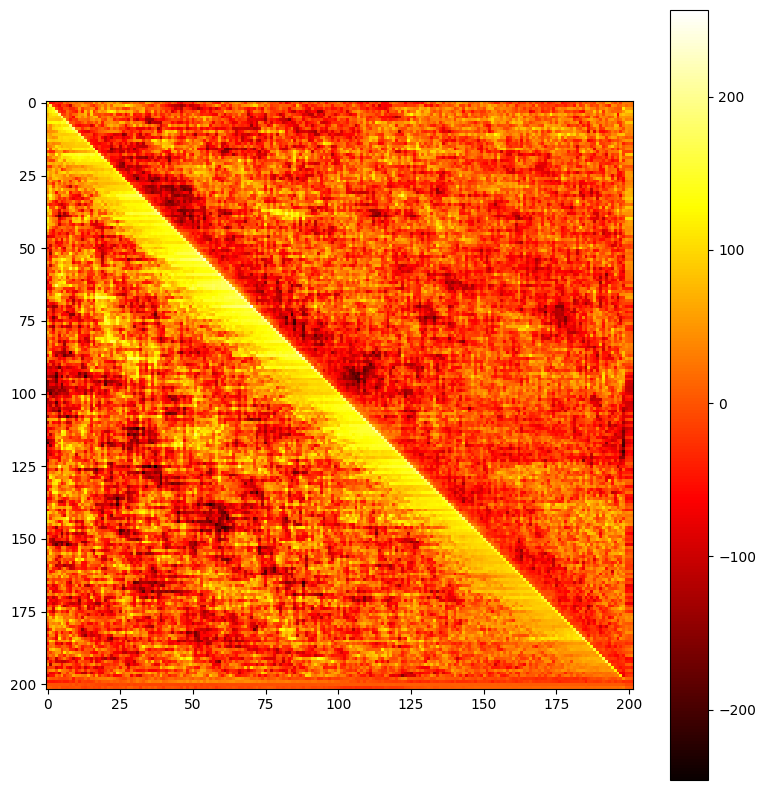

In [22]:
def plot_ov_heatmap(model, pos=-1):
  attn = model.blocks[0].attn
  all_token_embeddings = model.embed(range(D_VOCAB))

  token_embeddings_at_pos = all_token_embeddings + model.pos_embed(all_token_embeddings)[:,pos,:] if pos > -1 else all_token_embeddings

  embeddings_value = einsum("d_vocab d_model, n_heads d_model d_head -> n_heads d_vocab d_head",
                          token_embeddings_at_pos, attn.W_V)

  embeddings_out = einsum("n_heads d_vocab d_model, n_heads d_model d_model1 -> n_heads d_vocab d_model1",
                        embeddings_value, attn.W_O)

  ov_circuit_attn_heatmap = model.unembed(embeddings_out).detach().cpu()

  fig, ax = plt.subplots(figsize=(8, 8))
  graph = ax.imshow(ov_circuit_attn_heatmap[0], cmap="hot", interpolation="nearest")
  plt.colorbar(graph)
  plt.tight_layout()

plot_ov_heatmap(model)

In [23]:
if not ATTN_ONLY:
  OV = model.W_E @ model.W_V[0, 0] @ model.W_O[0, 0] @ model.W_in[0]
  imshow(OV, yaxis="Input Vocab", xaxis="Neuron")

# Observations

Repetition Not Allowed:
1. The model algorithm when not using MLP is similar to the [max over list](https://colab.research.google.com/drive/1WdvPyO-bB6l-iWq8SYjiovHp5R3834wN?usp=sharing) task. QV circuits both attend heavily towards successor tokens. Both are using OV circuits' copy mechanism.
2. Position Embedding is not necessary, and slows down convergence.

Repetition Allowed:
1. Position Embedding is important for 1 layer, but not necessary for > 1 layer.
2. Almost all MLP neurons are not important, and not necessary for the task.  
3. QV circuits attention patterns remain the same for different setup.
4. Different OV circuit attention pattern with different numbers of head
    - greater= 4H: vertical stripe pattern (high copy score)
    - 2H: Copy score decrease by .5 (using another mechanism simultaneously?)
    - 1H: Several phase changes(high copy score). But with MLP, it learns way faster (copy score decrease)
    
